## CA-2

In [3]:
# importing libraries
import pandas as pd
import time
import re
import string

In [4]:
# Helper functions

def time_elapsed_start():
    return time.time()

def time_elapsed_stop(start):
    sec = time.time() - start
    min = sec/60
    hour = min/60
    print(f"Execution took {sec} seconds - ({min} minutes), ({hour} hours)")

In [130]:
# loading data
ROWS_TO_READ = 200000
df = pd.read_csv('quora_questions.csv', nrows=ROWS_TO_READ)

In [131]:
df.sample(5)

,question
174726,Why does it take so long for amazon to ship?
154585,What is the best diet chart for a student prep...
35459,Is there a Drug and Alcohol Rehab Center in Ju...
2108,Is it possible for a mobile phone to explode?
94343,How beautifully life can be described?


In [132]:
for i in range(0, 10):
    print(df['question'][i])

What is the step by step guide to invest in share market in india?
What is the story of Kohinoor (Koh-i-Noor) Diamond?
How can I increase the speed of my internet connection while using a VPN?
Why am I mentally very lonely? How can I solve it?
Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Should I buy tiago?
How can I be a good geologist?
When do you use ã‚· instead of ã—?
Motorola (company): Can I hack my Charter Motorolla DCX3400?


In [133]:
# dataframe size|
print(f"Dataframe size: {df.size}")

Dataframe size: 200000


### Pre-processing

We are considering that a word should come in atleast 2 documents and should not come in more than 90% of the documents.

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=1, stop_words='english')

In [135]:
start = time_elapsed_start()
term_matrix = count_vectorizer.fit_transform(df['question'])
time_elapsed_stop(start)

Execution took 3.311908483505249 seconds - (0.05519847472508748 minutes), (0.000919974578751458 hours)


In [136]:
term_matrix

<200000x50470 sparse matrix of type '<class 'numpy.int64'>'
	with 1004332 stored elements in Compressed Sparse Row format>

The vector has taken 27,884 words in the vocabulary from 2,00,000 questions(rows).

# Applying LDA

In [137]:
from sklearn.decomposition import LatentDirichletAllocation

In [138]:
lda = LatentDirichletAllocation(n_components=14, random_state=3)

In [139]:
start = time_elapsed_start()
lda.fit(term_matrix)
time_elapsed_stop(start)

Execution took 442.35561871528625 seconds - (7.372593645254771 minutes), (0.12287656075424618 hours)


Checking log likelihood, perplexity

In [140]:
start = time_elapsed_start()
log_likelihood = lda.score(term_matrix)
perplexity = lda.perplexity(term_matrix)
time_elapsed_stop(start)

Execution took 105.48867440223694 seconds - (1.7581445733706156 minutes), (0.029302409556176925 hours)


In [141]:
print(f"Log likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

Log likelihood: -8936056.746951483
Perplexity: 5736.284365840458


In [142]:
# Creating a metrics dataframe for comparison later
lda_metrics_df = pd.DataFrame([[log_likelihood, perplexity, 13, 0.7]], columns=['log_likelihood', 'perplexity', 'n_components', 'learning_decay'])

In [143]:
lda_metrics_df

,log_likelihood,perplexity,n_components,learning_decay
0,-8.936057e+06,5736.284366,13,0.7


## Applying GridSearch for finding out best parameters for LDA

In [144]:
# importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

In [145]:
# creating parameters for LDA
params = {'n_components': [10, 12, 14], 'learning_decay': [.5, .7, .9]}

In [146]:
# Initializing evaluate LDA and passing parameters to it
eval_lda = LatentDirichletAllocation()
eval_lda = GridSearchCV(eval_lda, param_grid=params)

In [98]:
# Fitting the model
# this will search for optimal parameters
# Note: this process consumes a significant amount of time and resources
start = time_elapsed_start()
eval_lda.fit(term_matrix)
time_elapsed_stop(start)

Execution took 34.33424115180969 seconds - (0.5722373525301615 minutes), (0.009537289208836026 hours)


In [99]:
# Best Model which gave highest score 
best_lda_model = eval_lda.best_estimator_

# Model Parameters is used to store a list of parameter settings dicts for all the parameter candidates
print("Best Model's Params: ", eval_lda.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", eval_lda.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(term_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -25177.141092697868
Model Perplexity:  5496.049908100983


In [100]:
lda = LatentDirichletAllocation(n_components=10, random_state=3)

In [101]:
start = time_elapsed_start()
lda.fit(term_matrix)
time_elapsed_stop(start)

Execution took 1.993041753768921 seconds - (0.03321736256281535 minutes), (0.0005536227093802559 hours)


In [102]:
start = time_elapsed_start()
log_likelihood = lda.score(term_matrix)
perplexity = lda.perplexity(term_matrix)
time_elapsed_stop(start)

Execution took 0.3686387538909912 seconds - (0.00614397923151652 minutes), (0.00010239965385860868 hours)


In [103]:
print(f"Log likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

Log likelihood: -42937.403544789515
Perplexity: 5571.572518924214


In [104]:
# storing metrics in metrics dataframe
lda_metrics_df.loc[-1] = [log_likelihood, perplexity, 12, 0.7]
lda_metrics_df.index = lda_metrics_df.index + 1
lda_metrics_df = lda_metrics_df.sort_index()

In [105]:
lda_metrics_df

,log_likelihood,perplexity,n_components,learning_decay
0,-42937.403545,5571.572519,12.0,0.7
1,-43537.043072,6284.807756,13.0,0.7


## Exploring topics and their words

We have 27,885 words in the vocabulary. 

In [106]:
lda.components_.shape

(10, 2682)

10 topics with 27,885 words

Exploring a random topic

In [107]:
random_topic = lda.components_[3]

In [108]:
import matplotlib.pyplot as plt

In [109]:
def show_chart(words, count, chart_title):
    d = pd.DataFrame({"Words": words, "Count": count})
    # Sort the dataframe by largest count
    d = d.sort_values(by=["Count"], ascending=False)
    ax = d.plot.bar(y="Count", x="Words", title=chart_title, figsize=(15, 10), legend=True, fontsize=12, rot=1)
    ax.set_xlabel("Frequent words", fontsize=12)
    ax.set_ylabel("Word count", fontsize=12)

used
500
long
years
universe
1000
learn
time
start
old
did
language
like
stop
best


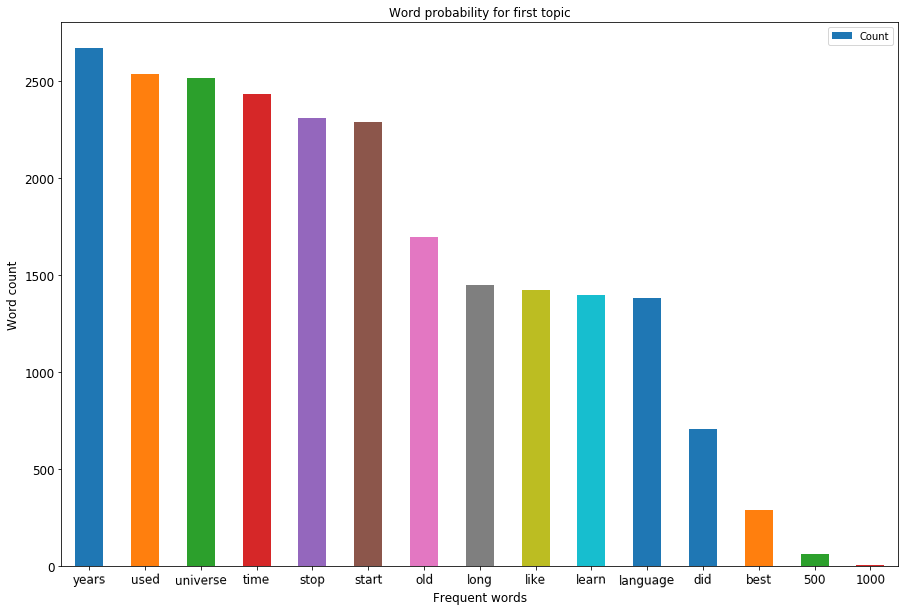

In [110]:
word_list = []
probability_list = []

for index in random_topic.argsort()[-15:]:
    frequent_word = count_vectorizer.get_feature_names()[index]
    print(frequent_word, sep=" ")
    word_list.append(frequent_word)
    probability_list.append(index)
    
show_chart(word_list, probability_list, "Word probability for first topic")

In [111]:
word_list = []
probability_list = []

top_number = 25
count = 0
for probability_number in lda.components_:
    text_message = f"Top words for topic {count} are : "
    print(text_message)    
    for number in probability_number.argsort()[-top_number:]:
        print([count_vectorizer.get_feature_names()[number]], end= "")
    print("\n")  
    count += 1

Top words for topic 0 are : 
['lakes']['degree']['state']['app']['purpose']['quality']['iphone']['compare']['meaning']['sex']['possible']['white']['taking']['interesting']['2016']['bachelors']['battle']['exist']['time']['school']['late']['does']['life']['best']['difference']

Top words for topic 1 are : 
['pros']['live']['2017']['gmail']['college']['science']['improve']['book']['series']['like']['computer']['android']['online']['english']['feel']['good']['mean']['learn']['prepare']['free']['year']['new']['does']['india']['best']

Top words for topic 2 are : 
['love']['mobile']['possible']['think']['play']['funds']['engineering']['better']['account']['india']['fm']['open']['canada']['change']['business']['cost']['feel']['learning']['way']['time']['does']['work']['best']['start']['good']

Top words for topic 3 are : 
['know']['lose']['friend']['india']['run']['programming']['relationship']['big']['bang']['work']['used']['500']['long']['years']['universe']['1000']['learn']['time']['start'

In [113]:
textfile_topics = lda.transform(term_matrix)

In [114]:
topic_list = []
# Textfile_topics is a list of arrays containing 
# all index positions of words for each textfile
for popular_index_pos in textfile_topics:
    # Get the max index position in each array
    # and add to the topic_list list
    topic_list.append(popular_index_pos.argmax())

# Add a new column to the dataframe
df["topic_num"] = topic_list

In [115]:
df

,question,topic_num
0,What is the step by step guide to invest in sh...,1
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,6
2,How can I increase the speed of my internet co...,7
3,Why am I mentally very lonely? How can I solve...,9
4,"Which one dissolve in water quikly sugar, salt...",7
5,Astrology: I am a Capricorn Sun Cap moon and c...,7
6,Should I buy tiago?,8
7,How can I be a good geologist?,2
8,When do you use ã‚· instead of ã—?,8
9,Motorola (company): Can I hack my Charter Moto...,3


In [116]:
df.loc[df['topic_num'] == 0].sample(5)

,question,topic_num
951,Which are the best part-time jobs to do in Ban...,0
856,What does it mean if a dog vomits white foam?,0
288,How do you deal with a fear of dying?,0
399,How do I pass a drug test for methamphetamine?,0
311,What are some unwritten rules in USA?,0


In [118]:
df.loc[df['topic_num'] == 1].sample(5)

,question,topic_num
187,What would happen if you cover one of your eye...,1
180,How do you get deleted Instagram chats?,1
858,How is the job situation in New Zealand for co...,1
738,Why is it that every teen girl has a crush on ...,1
352,How do I send message from one Android phone t...,1


In [119]:
df.loc[df['topic_num'] == 2].sample(5)

,question,topic_num
52,Nd she is always sad?,2
624,What are cheap and budget stay options in Nort...,2
345,What is the VTU 1st sem exam time table of 201...,2
353,What are the most important books ever written?,2
482,What are some cute shounen ai series?,2


In [120]:
df.loc[df['topic_num'] == 3].sample(5)

,question,topic_num
67,Can we ever store energy produced in lightning?,3
910,Why have I been so angry lately?,3
259,What will happen if I cancel TQWL tickets befo...,3
756,How can I calculate 72 hours from now?,3
43,Is being a good kid and not being a rebel wort...,3


In [121]:
df.loc[df['topic_num'] == 4].sample(5)

,question,topic_num
772,What is the main difference between socialism ...,4
808,What are the differences between larceny and r...,4
471,Is it wrong for me to be content with my life?,4
942,Can I overdraft my Wells Fargo account?,4
230,How many Champions are there in League of Lege...,4


In [122]:
df.loc[df['topic_num'] == 5].sample(5)

,question,topic_num
692,"In C++, what are access modifiers?",5
971,What exactly is MIKE2.0 (in layman's terms)?,5
736,What are the multiple uses of hollow columns?,5
527,What are the best places to recommend foreigne...,5
274,How do you feel when someone upvotes your answ...,5


In [123]:
df.loc[df['topic_num'] == 6].sample(5)

,question,topic_num
731,Why did Venuetastic fail?,6
821,"What's the meaning of ""I gotta take a shit!""?",6
722,How will I contact a good hacker?,6
61,Is it normal to have a dark ring around the ir...,6
653,Is (male) circumcision required in Islam?,6


In [124]:
df.loc[df['topic_num'] == 7].sample(5)

,question,topic_num
13,What was your first sexual experience like?,7
560,What are some common facts every mechanical en...,7
119,Should the toothbrush be wet or dry before app...,7
541,Is it necessary to unlock bootloader before ro...,7
737,Which are some commonly mispronounced words?,7


In [125]:
df.loc[df['topic_num'] == 8].sample(5)

,question,topic_num
354,What universities does Sigma Designs recruit n...,8
402,Do cricket players really drink tea on a tea b...,8
592,How is time travel possible?,8
427,How can the drive from Brooklyn to Staten Isla...,8
45,What is the quickest way to increase Instagram...,8


In [126]:
df.loc[df['topic_num'] == 9].sample(5)

,question,topic_num
173,Does anyone see the relation between Greek god...,9
829,What are common required and elective courses ...,9
865,What is the main reason for all the problems i...,9
917,Does all Muslims hate Narendra Modi?,9
3,Why am I mentally very lonely? How can I solve...,9


In [128]:
topic_list = {0: "Opinions", 
              1: "Recreation, Sports, Travel, and Activities", 
              2: "Quora", 
              3: "Finances/Earning Money", 
              4: "Life", 
              5: "World Politics", 
              6: "Learning, Programming, and Education", 
              7: "US Presedential Elections", 
              8: "Career and Motivation", 
              9: "Relationship"}

topic = df["topic_num"].map(topic_list)
df["topic"] = topic

In [129]:
df.head(25)

,question,topic_num,topic
0,What is the step by step guide to invest in sh...,1,"Recreation, Sports, Travel, and Activities"
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,6,"Learning, Programming, and Education"
2,How can I increase the speed of my internet co...,7,US Presedential Elections
3,Why am I mentally very lonely? How can I solve...,9,Relationship
4,"Which one dissolve in water quikly sugar, salt...",7,US Presedential Elections
5,Astrology: I am a Capricorn Sun Cap moon and c...,7,US Presedential Elections
6,Should I buy tiago?,8,Career and Motivation
7,How can I be a good geologist?,2,Quora
8,When do you use ã‚· instead of ã—?,8,Career and Motivation
9,Motorola (company): Can I hack my Charter Moto...,3,Finances/Earning Money


In [ ]:
df.to_csv('lda_modelled.csv')